In [1]:
import einops
import numpy as np


def HOSVD_3d(tensor, r1, r2, r3):
    n1, n2, n3 = tensor.shape

    a1 = einops.rearrange(tensor, "n1 n2 n3 -> n1 (n2 n3)")
    u, s, v = np.linalg.svd(a1, full_matrices=False)
    v1 = u[:, :r1].T
    
    a1 = np.diag(s[:r1]) @ v[:r1, :]
    a1 = einops.rearrange(a1, "r1 (n2 n3) -> (r1 n3) n2", n2=n2)
    
    u, s, v = np.linalg.svd(a1, full_matrices=False)
    v2 = v[:r2, :]

    u2 = u[:, :r2] @ np.diag(s[:r2])
    u2 = einops.rearrange(u2, "(r1 n3) r2 -> (r1 r2) n3", r1=r1)

    u, s, v = np.linalg.svd(u2, full_matrices=False)
    v3 = v[:r3, :]

    g = u[:, :r3] @ np.diag(s[:r3])

    g = einops.rearrange(g, "(r1 r2) r3 -> r1 r2 r3", r1=r1)

    return g, v1, v2, v3

In [32]:
def HOSVD_mnogo_d(tensor, rank_tuple):
    tshape = tensor.shape
    shape_dict = {f"n_{i}": tshape[i] for i in range(len(rank_tuple))}
    d = len(tshape)
    v_list = []
    prev_a = tensor
    for d_no in range(d):
        inp_pattern = " ".join([f"n_{i}" for i in range(d)])
        out_pattern_part_1 = " ".join([f"n_{i}" for i in range(d_no)])
        out_pattern_part_2 = " ".join([f"n_{i}" for i in range(d_no + 1, d)])
        out_pattern = f"({out_pattern_part_1} {out_pattern_part_2}) n_{d_no}"
        pattern = f"{inp_pattern} -> {out_pattern}"
        cutted_shape_dict = shape_dict.copy()
        inverse_pattern = f"{out_pattern} -> {inp_pattern}"

        a = einops.rearrange(prev_a, pattern)
        u, s, v = np.linalg.svd(a, full_matrices=False)
        v_list.append(v[:rank_tuple[d_no], :])

        shape_dict[f"n_{d_no}"] = rank_tuple[d_no]

        prev_a = u[:, :rank_tuple[d_no]] @ np.diag(s[:rank_tuple[d_no]])

        cutted_shape_dict.pop(f"n_{d_no}")
        prev_a = einops.rearrange(prev_a, inverse_pattern, **cutted_shape_dict)

    return prev_a, v_list

In [33]:
from PIL import Image
import numpy as np

# Загружаем jpg картинку при помощи PIL
image = Image.open('amanita.jpg')

# Переводим картинку в массив numpy
image_array = np.array(image)
"""[1:, 1:]
image_array = (image_array - image_array.min()) / (image_array.max() - image_array.min())
image_array = einops.reduce(image_array, "(h 4) (w 4) c -> h w c", 'mean')"""

# Проверяем размерность массива
print(image_array.shape)

(225, 225, 3)


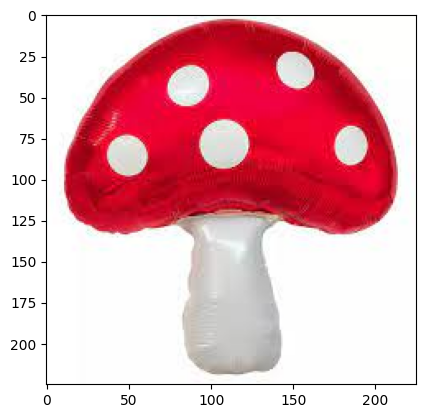

In [34]:
import matplotlib.pyplot as plt

plt.imshow(image_array)

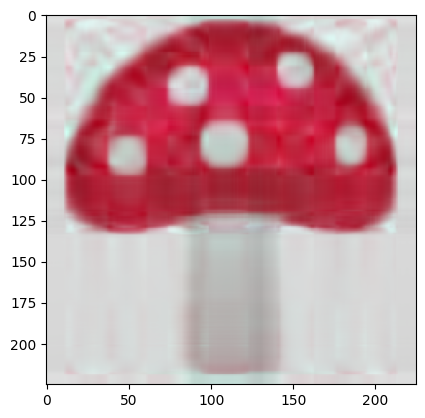

In [44]:
r = 10
g, v = HOSVD_mnogo_d(image_array, (r, r, r))
rec = einops.einsum(g, v[0], v[1], v[2], "alpha beta gamma, alpha i, beta j, gamma k -> i j k")
plt.imshow((rec - rec.min()) / (rec.max() - rec.min()))